# Reading in intial dataset

In [61]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline



train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

df_data = pd.concat([train,test])
df_data[885:895]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
885,886,0.0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0.0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1.0,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1.0,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C
890,891,0.0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S


## Title Variable Extraction (Only for replacing the age with title median)

In [62]:
df_data["Title"] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

df_data["Title"] = df_data["Title"].replace('Master', 'Master')
df_data["Title"] = df_data["Title"].replace('Mlle', 'Miss')
df_data["Title"] = df_data["Title"].replace(['Mme', 'Dona', 'Ms'], 'Mrs')
df_data["Title"] = df_data["Title"].replace(['Don','Jonkheer'],'Mr')
df_data["Title"] = df_data["Title"].replace(['Capt','Rev','Major', 'Col','Dr'], 'Military')
df_data["Title"] = df_data["Title"].replace(['Lady', 'Countess','Sir'], 'Honor')

train["Title"] = df_data['Title'][:891]
test["Title"] = df_data['Title'][891:]

# convert Title categories to Columns
titledummies=pd.get_dummies(train[['Title']], prefix_sep='_') #Title
train = pd.concat([train, titledummies], axis=1) 
ttitledummies=pd.get_dummies(test[['Title']], prefix_sep='_') #Title
test = pd.concat([test, ttitledummies], axis=1) 

print(train.columns,test.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Title_Honor',
       'Title_Master', 'Title_Military', 'Title_Miss', 'Title_Mr',
       'Title_Mrs'],
      dtype='object') Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Title_Master',
       'Title_Military', 'Title_Miss', 'Title_Mr', 'Title_Mrs'],
      dtype='object')


## Missing Values

In [63]:
# TRAIN

na_counts = {col: train[col].isna().sum() for col in train}

na_table = pd.DataFrame.from_dict(na_counts, orient='index', columns=['NA_Count'])

print(na_table)

# TEST

na_counts2 = {col: test[col].isna().sum() for col in test}

na_table2 = pd.DataFrame.from_dict(na_counts2, orient='index', columns=['NA_Count'])

print(na_table2)

                NA_Count
PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                  177
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                687
Embarked               2
Title                  0
Title_Honor            0
Title_Master           0
Title_Military         0
Title_Miss             0
Title_Mr               0
Title_Mrs              0
                NA_Count
PassengerId            0
Pclass                 0
Name                   0
Sex                    0
Age                   86
SibSp                  0
Parch                  0
Ticket                 0
Fare                   1
Cabin                327
Embarked               0
Title                  0
Title_Master           0
Title_Military         0
Title_Miss             0
Title_Mr               0
Title_Mrs              0


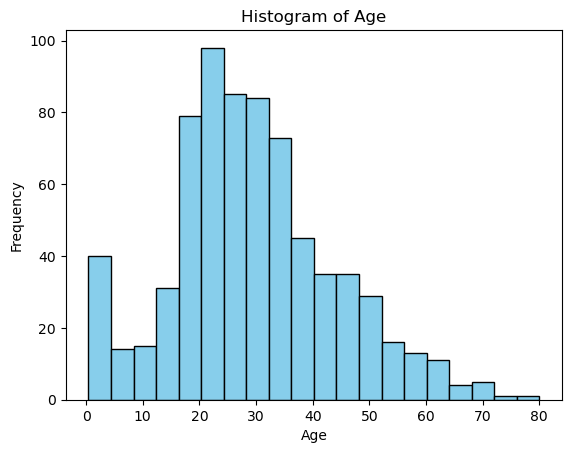

In [64]:
plt.hist(train['Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')

# Show plot
plt.show()

### Replacing NA's

#### AGE by mean (Ignore)

In [206]:
#df_data["Age"] = train["Age"].fillna(round(train["Age"].mean())) # Try dropping null age rows instead of imputing the mean


#plt.hist(train['Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
#plt.xlabel('Age')
#plt.ylabel('Frequency')
#plt.title('Histogram of Age')

# Show plot
#plt.show()

#### Age by title median

Title:Master, Median:4.0
Title:Miss, Median:22.0
Title:Mr, Median:29.0
Title:Mrs, Median:35.0
Title:Military, Median:49.5
Title:Honor, Median:48.0
Missing Ages Estimated


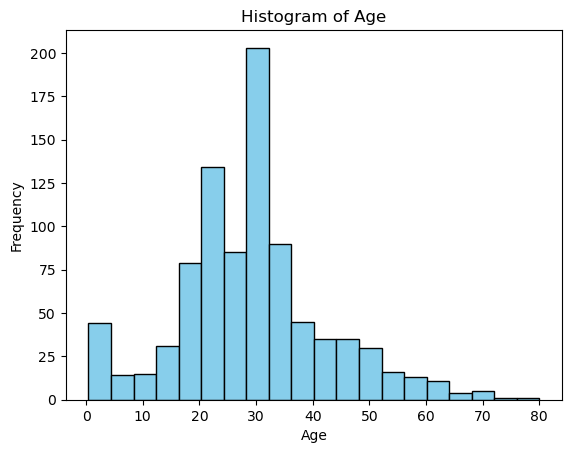

In [65]:
df_data[df_data['Title'] == "Master"]['Age'].describe()

titles = ['Master', 'Miss', 'Mr', 'Mrs', 'Military','Honor']
for title in titles:
    age_to_impute = df_data.groupby('Title')['Age'].median()[title]
    print(f'Title:{title}, Median:{age_to_impute}')
    df_data.loc[(df_data['Age'].isnull()) & (df_data['Title'] == title), 'Age'] = age_to_impute
# Age in df_train and df_test:
train["Age"] = df_data['Age'][:891]
test["Age"] = df_data['Age'][891:]
print('Missing Ages Estimated')

plt.hist(train['Age'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')

# Show plot
plt.show()


In [66]:
na_counts = {col: test[col].isna().sum() for col in test}

na_table = pd.DataFrame.from_dict(na_counts, orient='index', columns=['NA_Count'])

print(na_table)

                NA_Count
PassengerId            0
Pclass                 0
Name                   0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Ticket                 0
Fare                   1
Cabin                327
Embarked               0
Title                  0
Title_Master           0
Title_Military         0
Title_Miss             0
Title_Mr               0
Title_Mrs              0


## Dummies and Drops

In [67]:
train = pd.get_dummies(train, columns=['Pclass'], prefix=['class'])
test = pd.get_dummies(test, columns=['Pclass'], prefix=['class'])
train[['class_1', 'class_2', 'class_3']] = train[['class_1', 'class_2', 'class_3']].astype(int)
test[['class_1', 'class_2', 'class_3']] = test[['class_1', 'class_2', 'class_3']].astype(int)

train["Sex"] = pd.get_dummies(train[["Sex"]], drop_first = True)
train.rename(columns={'Sex': 'Male'}, inplace=True)
test["Sex"] = pd.get_dummies(test[["Sex"]], drop_first = True)
test.rename(columns={'Sex': 'Male'}, inplace=True)


train = train.drop(["Name", "Ticket", "Embarked", "Cabin"], axis = 1)
train = train.drop(['Title'], axis = 1)

title_list = ['Title_Honor','Title_Master','Title_Military','Title_Miss','Title_Mr','Title_Mrs']

train = train.drop(title_list, axis = 1)

test = test.drop(["Name", "Ticket", "Embarked", "Cabin"], axis = 1)
test = test.drop(['Title'], axis = 1)

test_title_list = ['Title_Master','Title_Military', 'Title_Miss', 'Title_Mr', 'Title_Mrs']

test = test.drop(test_title_list, axis = 1)

test['Fare'].fillna(value = round(test['Fare'].mean()), inplace = True)

print(train.columns, test.columns)

Index(['PassengerId', 'Survived', 'Male', 'Age', 'SibSp', 'Parch', 'Fare',
       'class_1', 'class_2', 'class_3'],
      dtype='object') Index(['PassengerId', 'Male', 'Age', 'SibSp', 'Parch', 'Fare', 'class_1',
       'class_2', 'class_3'],
      dtype='object')


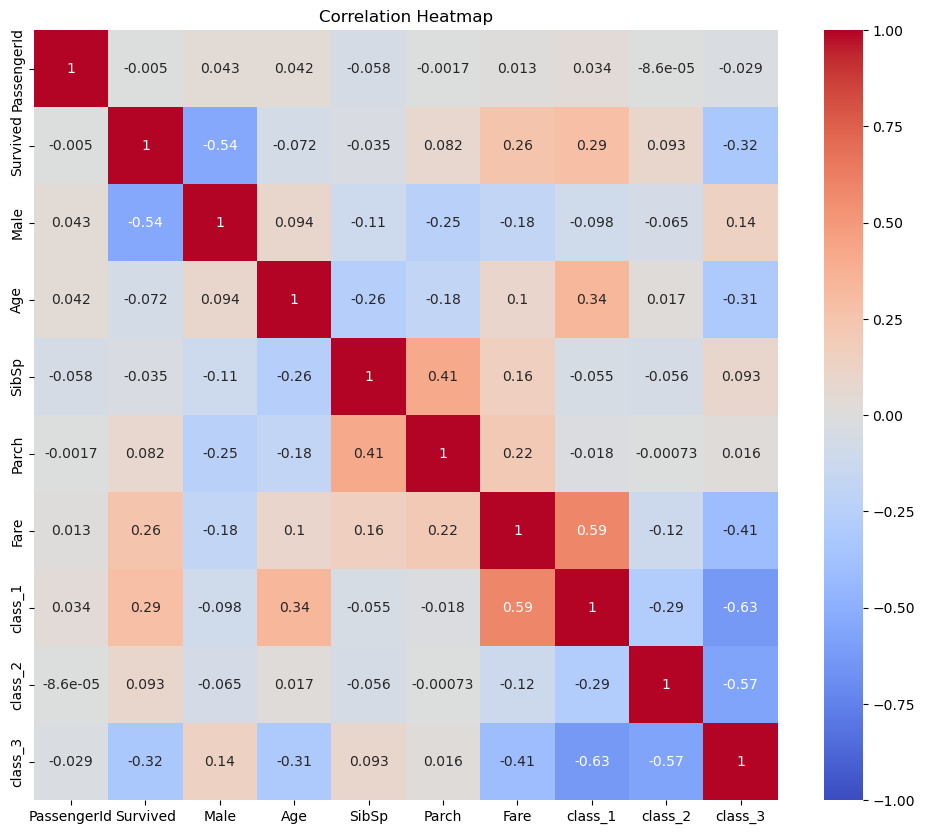

In [7]:
corr_train = train.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_train, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [8]:
test_train = train
test_train['Intercept'] = 1

# Create a DataFrame with only the predictor variables
X = test_train[['Fare', 'class_1','class_2', 'Intercept']]

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)
train = train.drop(columns = ['Intercept'])

    Variable       VIF
0       Fare  1.545820
1    class_1  1.662552
2    class_2  1.095860
3  Intercept  1.931867


It looks like there's not enough evidence of multicollinearity to justify not including either the Fare or the Class Variable in the model.

# x_train, y_train, x_test, y_test

In [68]:
print(train.columns,test.columns)

Index(['PassengerId', 'Survived', 'Male', 'Age', 'SibSp', 'Parch', 'Fare',
       'class_1', 'class_2', 'class_3'],
      dtype='object') Index(['PassengerId', 'Male', 'Age', 'SibSp', 'Parch', 'Fare', 'class_1',
       'class_2', 'class_3'],
      dtype='object')


In [10]:
x_train = train[['Male', 'Age', 'SibSp', 'Parch', 'Fare','class_1', 'class_2', 'class_3']]
y_train = train[['Survived']]

x_test = test[['Male', 'Age', 'SibSp', 'Parch', 'Fare','class_1', 'class_2', 'class_3']]
y_test = gender_submission[['Survived']]

# Feature Selection

## RF

In [174]:
y_train = np.ravel(y_train)
feat_labels = x_train.columns
forest = RandomForestClassifier(n_estimators = 500,
                               random_state = 1,
                               n_jobs = 2)
forest.fit(x_train,y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("2%d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    
y_train = train[['Survived']]

21) Fare                           0.290995
22) Age                            0.269113
23) Male                           0.259165
24) class_3                        0.051100
25) SibSp                          0.047188
26) Parch                          0.035790
27) class_1                        0.031708
28) class_2                        0.014941


Obviously Fare, Age and Sex are the most important, but I wonder how deleting SibSp and ParCh would impact the model. Intuitively, I could see how having siblings or spouses / parents or children could impact the model, but I'm not sure how. I think for safety and to avoid too many model variables, removing them from the model would be ideal.

## PCA (Work in Progress)

In [52]:
'''
def PCA()

pca = PCA()
x_train_pca = pca.fit_transform(x_train)
pca.explained_variance_ratio_

plt.bar(range(0, 15), pca.explained_variance_ratio_, align='center',label='Individual explained variance')
plt.step(range(0, 15), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')

plt.show()'''

NameError: name 'x_train' is not defined

# Train + Eval function

In [20]:
model_accuracy_titanic_compare = {}
model_accuracy_titanic_compare_piped = {}


def train_eval(mod, scaler, x_train_features, y_train_labels, x_test_features, y_test_labels):
    x_train_scaled = scaler.fit_transform(x_train_features)
    x_test_scaled = scaler.transform(x_test_features)
    
    y_train_labels = np.ravel(y_train_labels)
    mod.fit(x_train_scaled, y_train_labels)
    y_predict = mod.predict(x_test_scaled)
    
    accuracy = accuracy_score(y_test_labels, y_predict)
    
    if mod.__class__.__name__ == "SVC":
        model_key = f"{mod.__class__.__name__} ({mod.kernel}) - {scaler.__class__.__name__}"
    else:
         model_key = f"{mod.__class__.__name__} - {scaler.__class__.__name__}"
        
       
    model_accuracy_titanic_compare[model_key] = accuracy
    
    return accuracy

def piped_traineval(mod, scaler, x_train_features, y_train_labels, x_test_features, y_test_labels):
    pipe = make_pipeline(scaler, mod)
    pipe.fit(x_train_features, y_train_labels)
    y_pred = pipe.predict(x_test_features)
    accuracy = accuracy_score(y_test_labels, y_pred)

    if mod.__class__.__name__ == "SVC":
        model_key = f"{mod.__class__.__name__} ({mod.kernel}) - {scaler.__class__.__name__}"
    else:
        model_key = f"{mod.__class__.__name__} - {scaler.__class__.__name__}"

    model_accuracy_titanic_compare_piped[model_key] = accuracy

    return accuracy


# Data Scaling Init

In [12]:
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

# Models (1 model for each scaler function)

## Logistic Regression

In [22]:
# Initialize Models
lr_mod = LogisticRegression()
lr_mod2 = LogisticRegression()
lr_mod3 = LogisticRegression()

# Train and Evaluate models

lr_mod_standard_scaler = train_eval(lr_mod, standard_scaler, x_train, y_train, x_test, y_test)
lr_mod_minmax_scaler = train_eval(lr_mod, minmax_scaler, x_train, y_train, x_test, y_test)
lr_mod_robust_scaler = train_eval(lr_mod, robust_scaler, x_train, y_train, x_test, y_test)

lr_mod_standard_scaler = piped_traineval(lr_mod, standard_scaler, x_train, y_train, x_test, y_test)
lr_mod_minmax_scaler = piped_traineval(lr_mod, minmax_scaler, x_train, y_train, x_test, y_test)
lr_mod_robust_scaler = piped_traineval(lr_mod, robust_scaler, x_train, y_train, x_test, y_test)



print(model_accuracy_titanic_compare)
print(model_accuracy_titanic_compare_piped)

{'LogisticRegression - StandardScaler': 0.9330143540669856, 'LogisticRegression - MinMaxScaler': 0.9593301435406698, 'LogisticRegression - RobustScaler': 0.9330143540669856}
{'LogisticRegression - StandardScaler': 0.9330143540669856, 'LogisticRegression - MinMaxScaler': 0.9593301435406698, 'LogisticRegression - RobustScaler': 0.9330143540669856}


/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### SBS + LR (work in progress)

In [65]:
'''
sbs = SequentialFeatureSelector(lr, n_features_to_select = 8)
sbs.fit(x_train_std, y_train)

print(x_train.columns[list(np.where(sbs.get_support())[0])])

x_train_sbs = x_train_std[:,list(np.where(sbs.get_support())[0])]

lr_sbs = LogisticRegression(C = 100, solver = 'lbfgs', multi_class = 'multinomial')
lr_sbs.fit(x_train_sbs,y_train)

y_pred = lr_sbs.predict(x_test_std[:,list(np.where(sbs.get_support())[0])])

print("Accuracy: %0.3f" % accuracy_score(y_test,y_pred))
if highscore > accuracy_score(y_test,y_pred):
    print(f"Highscore: {highscore.round(3)}")
elif highscore < accuracy_score(y_test,y_pred):
    highscore = accuracy_score(y_test,y_pred)
    print(f"New Highscore: {highscore.round(3)}")
else:
    print("Score = Highscore")
    '''

'\nsbs = SequentialFeatureSelector(lr, n_features_to_select = 8)\nsbs.fit(x_train_std, y_train)\n\nprint(x_train.columns[list(np.where(sbs.get_support())[0])])\n\nx_train_sbs = x_train_std[:,list(np.where(sbs.get_support())[0])]\n\nlr_sbs = LogisticRegression(C = 100, solver = \'lbfgs\', multi_class = \'multinomial\')\nlr_sbs.fit(x_train_sbs,y_train)\n\ny_pred = lr_sbs.predict(x_test_std[:,list(np.where(sbs.get_support())[0])])\n\nprint("Accuracy: %0.3f" % accuracy_score(y_test,y_pred))\nif highscore > accuracy_score(y_test,y_pred):\n    print(f"Highscore: {highscore.round(3)}")\nelif highscore < accuracy_score(y_test,y_pred):\n    highscore = accuracy_score(y_test,y_pred)\n    print(f"New Highscore: {highscore.round(3)}")\nelse:\n    print("Score = Highscore")\n    '

Interesting that the accuracy went down a little bit after feature selection

In [54]:
'''sbs2 = SequentialFeatureSelector(lr, n_features_to_select = 5)
sbs2.fit(x_train_std, y_train)

print(x_train.columns[list(np.where(sbs2.get_support())[0])])

x_train_sbs2 = x_train_std[:,list(np.where(sbs2.get_support())[0])]

lr_sbs2 = LogisticRegression(C = 100, solver = 'lbfgs', multi_class = 'multinomial')
lr_sbs2.fit(x_train_sbs2,y_train)

y_pred = lr_sbs2.predict(x_test_std[:,list(np.where(sbs2.get_support())[0])])

print("Accuracy: %0.3f" % accuracy_score(y_test,y_pred))
if highscore > accuracy_score(y_test,y_pred):
    print(f"Highscore: {highscore.round(3)}")
elif highscore < accuracy_score(y_test,y_pred):
    highscore = accuracy_score(y_test,y_pred)
    print(f"New Highscore: {highscore.round(3)}")
else:
    print("Score = Highscore")'''

Index(['Male', 'SibSp', 'Parch', 'Title_Master', 'class_3'], dtype='object')
Accuracy: 0.825
Highscore: 0.869


### LR with PCA (with titles)

#### n_components = 2

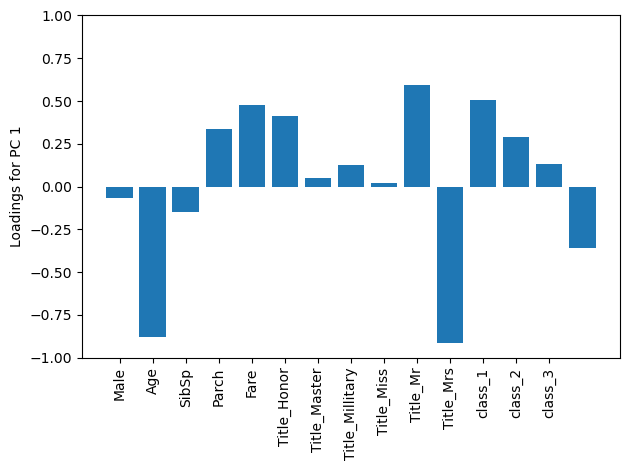

In [34]:
'''sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig, ax = plt.subplots()

ax.bar(range(15), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(14))
ax.set_xticklabels(x_train.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()'''

Definitely looks like there's a relationship there that's not being captured, and the classifier is only 80% accurate on the test case.

#### n_components = 3,4,5

## RF

In [23]:
#Initialize RF models

rf_mod = RandomForestClassifier(n_estimators = 29,
                               random_state=1,
                               n_jobs = 2,
                               max_depth = None,
                               min_samples_split = 10,
                               min_samples_leaf = 1,
                               max_leaf_nodes = 46)
rf_mod2 = RandomForestClassifier(n_estimators = 29,
                               random_state=1,
                               n_jobs = 2,
                               max_depth = None,
                               min_samples_split = 10,
                               min_samples_leaf = 1,
                               max_leaf_nodes = 46)
rf_mod3 = RandomForestClassifier(n_estimators = 29,
                               random_state=1,
                               n_jobs = 2,
                               max_depth = None,
                               min_samples_split = 10,
                               min_samples_leaf = 1,
                               max_leaf_nodes = 46)

rf_mod_standard_scaler = train_eval(rf_mod, standard_scaler, x_train, y_train, x_test, y_test)
rf_mod_minmax_scaler = train_eval(rf_mod2, minmax_scaler, x_train, y_train, x_test, y_test)
rf_mod_robust_scaler = train_eval(rf_mod3, robust_scaler, x_train, y_train, x_test, y_test)

rf_mod_standard_scaler = piped_traineval(rf_mod, standard_scaler, x_train, y_train, x_test, y_test)
rf_mod_minmax_scaler = piped_traineval(rf_mod2, minmax_scaler, x_train, y_train, x_test, y_test)
rf_mod_robust_scaler = piped_traineval(rf_mod3, robust_scaler, x_train, y_train, x_test, y_test)

model_accuracy_titanic_compare_piped

/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'LogisticRegression - StandardScaler': 0.9330143540669856,
 'LogisticRegression - MinMaxScaler': 0.9593301435406698,
 'LogisticRegression - RobustScaler': 0.9330143540669856,
 'RandomForestClassifier - StandardScaler': 0.8779904306220095,
 'RandomForestClassifier - MinMaxScaler': 0.8779904306220095,
 'RandomForestClassifier - RobustScaler': 0.8779904306220095}

### First RF

#### RF parameter iteration

#### Grid Search (Work In Progress (WIP))

Grid searching takes a really long time

## KNN

In [25]:
knn_mod = KNeighborsClassifier(n_neighbors = 5)
knn_mod2 = KNeighborsClassifier(n_neighbors = 5)
knn_mod3 = KNeighborsClassifier(n_neighbors = 5)

knn_mod_standard_scaler = piped_traineval(knn_mod, standard_scaler, x_train, y_train, x_test, y_test)
knn_mod_minmax_scaler = piped_traineval(knn_mod2, minmax_scaler, x_train, y_train, x_test, y_test)
knn_mod_robust_scaler = piped_traineval(knn_mod3, robust_scaler, x_train, y_train, x_test, y_test)

model_accuracy_titanic_compare_piped

/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


{'LogisticRegression - StandardScaler': 0.9330143540669856,
 'LogisticRegression - MinMaxScaler': 0.9593301435406698,
 'LogisticRegression - RobustScaler': 0.9330143540669856,
 'RandomForestClassifier - StandardScaler': 0.8779904306220095,
 'RandomForestClassifier - MinMaxScaler': 0.8779904306220095,
 'RandomForestClassifier - RobustScaler': 0.8779904306220095,
 'KNeighborsClassifier - StandardScaler': 0.8373205741626795,
 'KNeighborsClassifier - MinMaxScaler': 0.8373205741626795,
 'KNeighborsClassifier - RobustScaler': 0.8038277511961722}

## SVM

### Linear

In [26]:
svm_mod = SVC(kernel='linear', C=1)
svm_mod2 = SVC(kernel='linear', C=1)
svm_mod3 = SVC(kernel='linear', C=1)

svm_mod_standard_scaler = piped_traineval(svm_mod, standard_scaler, x_train, y_train, x_test, y_test)
svm_mod_minmax_scaler = piped_traineval(svm_mod2, minmax_scaler, x_train, y_train, x_test, y_test)
svm_mod_robust_scaler = piped_traineval(svm_mod3, robust_scaler, x_train, y_train, x_test, y_test)

model_accuracy_titanic_compare_piped

/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'LogisticRegression - StandardScaler': 0.9330143540669856,
 'LogisticRegression - MinMaxScaler': 0.9593301435406698,
 'LogisticRegression - RobustScaler': 0.9330143540669856,
 'RandomForestClassifier - StandardScaler': 0.8779904306220095,
 'RandomForestClassifier - MinMaxScaler': 0.8779904306220095,
 'RandomForestClassifier - RobustScaler': 0.8779904306220095,
 'KNeighborsClassifier - StandardScaler': 0.8373205741626795,
 'KNeighborsClassifier - MinMaxScaler': 0.8373205741626795,
 'KNeighborsClassifier - RobustScaler': 0.8038277511961722,
 'SVC (linear) - StandardScaler': 1.0,
 'SVC (linear) - MinMaxScaler': 1.0,
 'SVC (linear) - RobustScaler': 1.0}

### Non-Linear with Kernel

In [27]:
svm_nonlin_mod = SVC(kernel = "rbf", C = 1, random_state = 1, gamma = 0.1)
svm_nonlin_mod2 = SVC(kernel = "rbf", C = 1, random_state = 1, gamma = 0.1)
svm_nonlin_mod3 = SVC(kernel = "rbf", C = 1, random_state = 1, gamma = 0.1)

svm_nonlin_mod_standard_scaler = piped_traineval(svm_nonlin_mod, standard_scaler, x_train, y_train, x_test, y_test)
svm_nonlin_mod2_minmax_scaler = piped_traineval(svm_nonlin_mod2, minmax_scaler, x_train, y_train, x_test, y_test)
svm_nonlin_mod3_robust_scaler = piped_traineval(svm_nonlin_mod3, robust_scaler, x_train, y_train, x_test, y_test)

model_accuracy_titanic_compare_piped

/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'LogisticRegression - StandardScaler': 0.9330143540669856,
 'LogisticRegression - MinMaxScaler': 0.9593301435406698,
 'LogisticRegression - RobustScaler': 0.9330143540669856,
 'RandomForestClassifier - StandardScaler': 0.8779904306220095,
 'RandomForestClassifier - MinMaxScaler': 0.8779904306220095,
 'RandomForestClassifier - RobustScaler': 0.8779904306220095,
 'KNeighborsClassifier - StandardScaler': 0.8373205741626795,
 'KNeighborsClassifier - MinMaxScaler': 0.8373205741626795,
 'KNeighborsClassifier - RobustScaler': 0.8038277511961722,
 'SVC (linear) - StandardScaler': 1.0,
 'SVC (linear) - MinMaxScaler': 1.0,
 'SVC (linear) - RobustScaler': 1.0,
 'SVC (rbf) - StandardScaler': 0.9425837320574163,
 'SVC (rbf) - MinMaxScaler': 1.0,
 'SVC (rbf) - RobustScaler': 0.9354066985645934}

# Learning Curve

/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lukewilsen/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array w

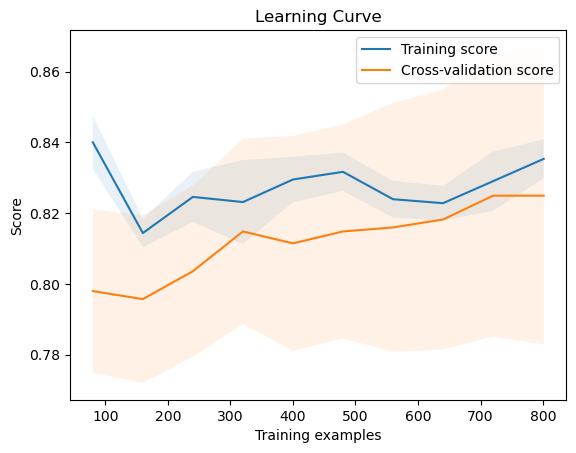

In [40]:
pipeline = make_pipeline(StandardScaler(),SVC(kernel = "rbf", C = 1, random_state = 1, gamma = 0.1))

train_sizes, train_scores, test_scores = learning_curve(
    pipeline, x_train, y_train, cv=10, n_jobs=3, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate means and standard deviations for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend()
plt.show()

## Kmeans

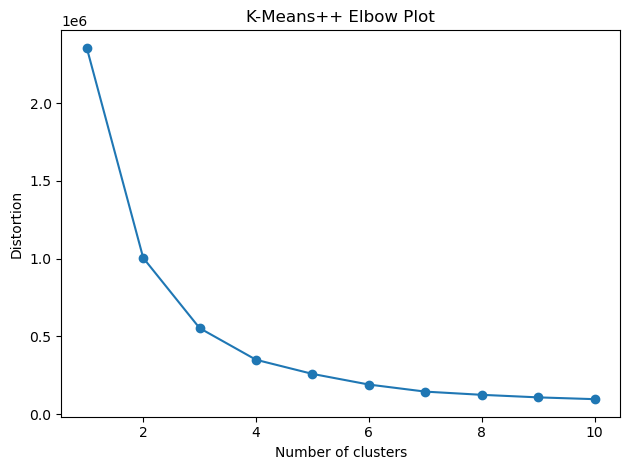

In [122]:
from sklearn.cluster import KMeans

distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300,
                random_state=0)
    km.fit(x_train)
    distortions.append(km.inertia_)


plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("K-Means++ Elbow Plot")
plt.tight_layout()
plt.show()    

## DBSCAN

In [52]:
print(sum(train["Survived"] == 1),sum(train['Survived'] == 0))

342 549


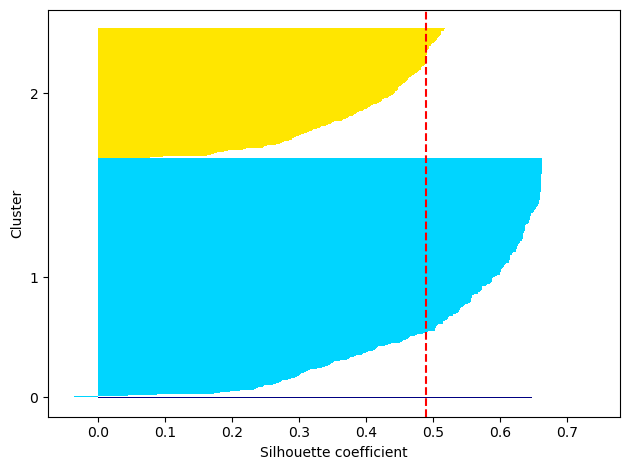

In [118]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler



features = train[['Male', 'Age', 'Fare']]

features = features.dropna()

scaler = StandardScaler()
features = scaler.fit_transform(features)
# Apply DBSCAN
db = DBSCAN(eps=1.5)
labels = db.fit_predict(features)

from sklearn.metrics import silhouette_samples
from matplotlib import cm

cluster_labels = np.unique(labels)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(features, labels, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[labels == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('figures/10_04.png', dpi=300)
plt.show()
